# DSCI 100 Group Project Proposal

team: Rachel Liang, Ziyan He, Yuchen Zhang, Zohane Bal

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("tests.R")
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


### Introduction    

The dataset we are working on is downloaded from the UCI Machine Learning Repository. Although the dataset contains four databases about the heart disease diagnosis from 4 different locations, we only picked the database collected from the Cleveland Clinic Foundation since it is the only data base that has full 14 attributes recored for each heart disease diagnosis. The total instances in this database is 303.

# Method and Result

### Load Data and Wrangle Data
This dataset does not need to be cleaned since it does not have any missing data or missing attributes. <br>
We added column names to the dataset and selected columns we needed for analysis. Also as we are treating some attributes's numeric values as categorical variables, we used as.factor() for conversion.

In [2]:
set.seed(1234)

heart_disease_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"


heart_disease_data <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num"))
heart_disease_data

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


### 14 Attributes Description
* Age: age in years
* Sex: ( 1 = male, 0 = female)
* Cp: chest pain type
Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4 asymptomatic
* Trestbps: Resting Blood pressure ( in mm Hg on admission to hospital)
* Chol: Serum cholesterol in mg/dl
* Fbs: Fastig blood suger > 120 (1 = true, 0 = false)
* Dm: 1 = history if diabetes , 0 = no such history)
* Restecg: Resting electro cardiac results
Value 0 : normal
Value 1: having ST-T wave abnormality ( T wave inversion and/or ST elevation or depression of > 0.05 mV)
Value 2” Showing probable or definite left ventricular hypertrophy by Estes’ criteria
* Thalach: maximum heart rate achieved
* Exang: exercise induced angina (1 = yes ,0 = no)
* Oldpeak:ST depression induced by exercise relative to rest
* Slope: The slope of the peak exercise ST segment
Value 1: upsloping
Value 2: flat
Value 3: downsloping
* Ca: Number of major vessels (0-3) coloured by fluorosopy
* Thal: 3 = normal , 6= fixed defect , 7 = reversible defect
* Num: diagnosis of heart disease
Value 0 <50% diameter narrowing
Value 1 > 50% Diameter narrowing

### Observation from the Correlation Plot
Through the correlation plot we found five predictors with relatively large absolute correlation value, which are cp, thalach, exang, oldpeak, and slope.<br> We excluded the two factors which are age and sex that we thought would have a great influence on the target variable, num. In the end, having the above five predictors chosen to predict the presence of heart disease.

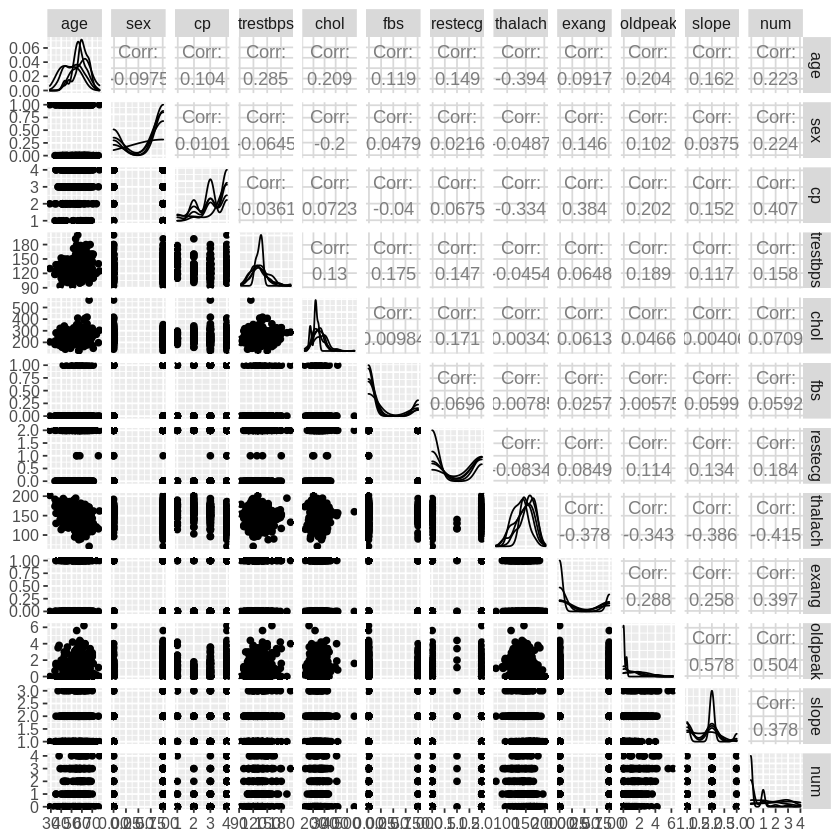

In [4]:
correlation_plot <- heart_disease_data %>% 
                select(-ca, -thal) %>% 
                ggpairs(heart_disease_data[1:12]) +
                theme(text = element_text(size = 12))


correlation_plot

### Some visualizations of the dataset
We try to visualize which type of chest pain occurs most often in different levels of heart disease(0 meaning zero probability of having heart diseanse, and 4 meaning the most probability of having a heart disease).<br>
We observed that individuals having type 4 chest pain which is asymptomatic chest pain, have the most probobility(4) of having heart disease.

`summarise()` regrouping output by 'num' (override with `.groups` argument)



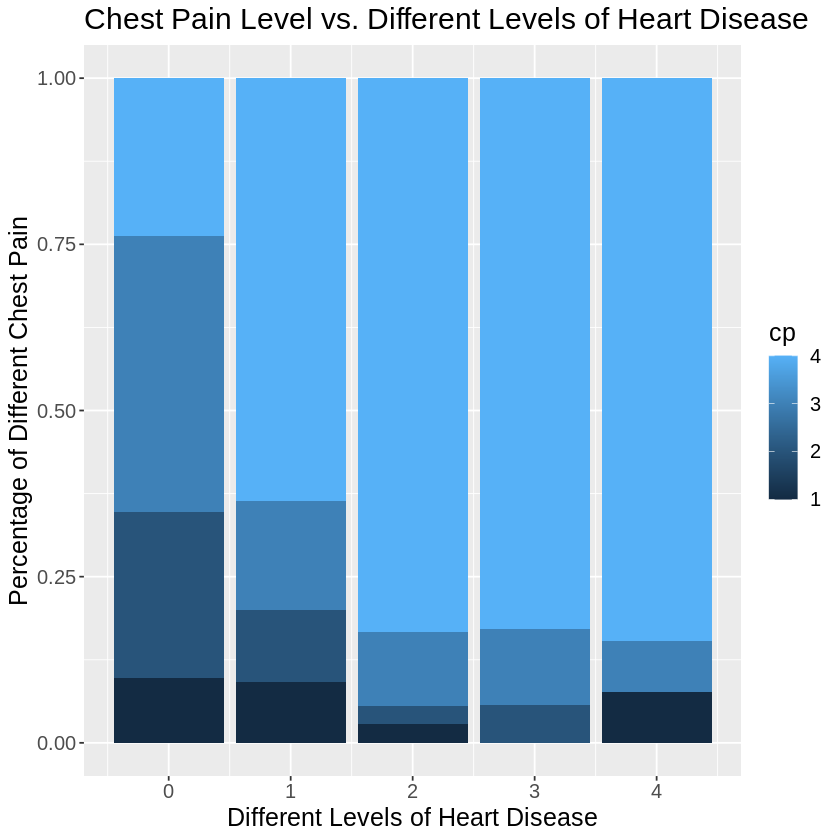

In [5]:
options(repr.plot.width = 7, repr.plot.height = 7)

cp_vs_num <- heart_disease_data %>% 
            select(num, cp) %>% 
            group_by(num, cp) %>% 
            summarize(n = n()) %>%
            ggplot(aes(x = num, y = n, fill = cp)) +
            labs(x="Different Levels of Heart Disease", y= "Percentage of Different Chest Pain")+
            geom_bar(stat = "identity",position = "fill") +
            ggtitle("Chest Pain Level vs. Different Levels of Heart Disease")+
            theme(text = element_text(size = 15))
cp_vs_num

`summarise()` regrouping output by 'num' (override with `.groups` argument)



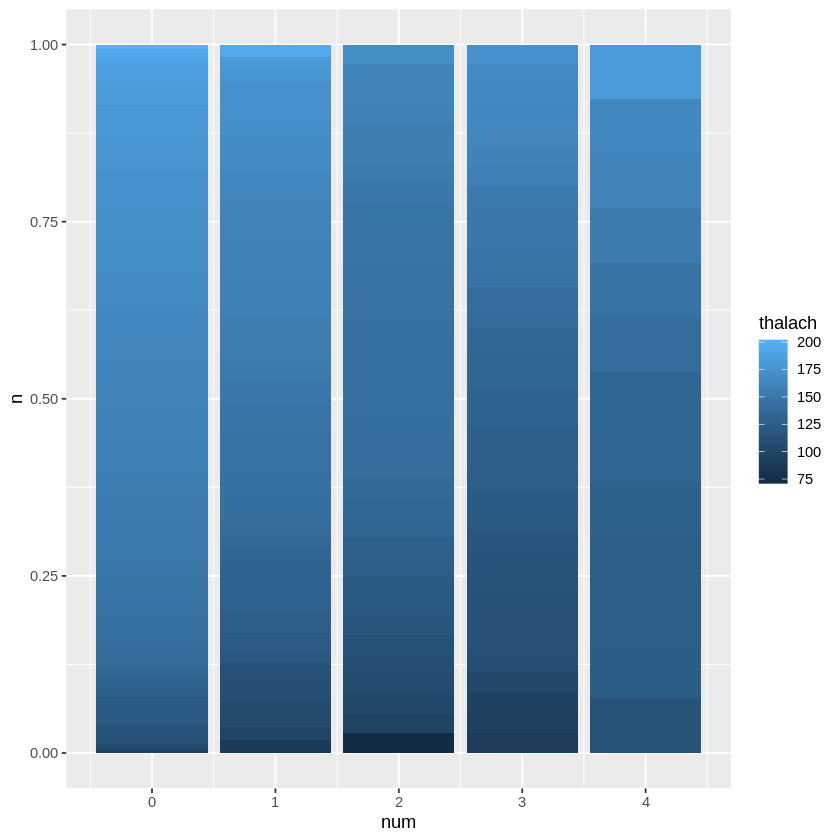

In [6]:
thalach_vs_num <- heart_disease_data %>% 
            select(num, thalach) %>% 
            group_by(num, thalach) %>% 
            summarize(n = n()) %>%
            ggplot(aes(x = num, y = n, fill = thalach)) +
            geom_bar(stat = "identity",position = "fill")
thalach_vs_num

### Check for balancing
We found the count and percentage of the probability of getting heart disease diagnosis observations in our data set. We observed that our heart disease data set has this “num” (diagnosis of heart disease) imbalance, that is, we have the class, the zero chance of getting heart disease label, more common than the others. We therefore resolve this issue by grouping all the non-zero probability levels of having heart diseases into one group. Thus, we will now have num having two classes.

In [7]:
num_obs <- nrow(heart_disease_data)
        heart_disease_data %>% 
        group_by(num) %>% 
        summarize(
        count = n(),
        percentage = n() / num_obs * 100)

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<dbl>,<int>,<dbl>
0,164,54.125413
1,55,18.151815
2,36,11.881188
3,35,11.551155
4,13,4.290429


drawing multiple histograms and the x-axis is the num (possibility of getting heart disease : 0, 1, 2, 3) and the y-axis is the count. color the bar using position "filled" with each column (such as cp, fbs according to the larger correlation in the ggpair). if this variable has a high correlation related to getting heart disease, the proportion of color will be filled more in the larger x-axis, and otherwise. Also use medical research to add ontop of the correlation because correlation does not mean causation.

In [8]:
heart_disease_data_5 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    mutate(num = replace(num, num =='2',1)) %>% 
                    mutate(num = replace(num, num =='3',1)) %>% 
                    mutate(num = replace(num, num =='4',1)) %>% 
                    select(cp, thalach, exang, slope, oldpeak, num) %>% 
                    mutate(num = as.factor(num))
                    
heart_disease_data_5                

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,1
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,115,1,2,1.2,1
2,174,0,2,0.0,1
3,173,0,1,0.0,0


### Check for balancing new

In [9]:
num_obs_5 <- nrow(heart_disease_data_5)
        heart_disease_data_5 %>% 
        group_by(num) %>% 
        summarize(
        count = n(),
        percentage = n() / num_obs_5 * 100)

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<fct>,<int>,<dbl>
0,164,54.12541
1,139,45.87459


### Split Into Training and Testing Dataset
Based on the number of instances in this dataset, we decided that setting 75% of the data in the dataset as training data and the remaining 25% as testing data will make a good balance for training the classifier and evaluating the classifier's accuracy.

## Mutating Num to binary categorical

In [58]:
heart_disease_data_5 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    mutate(num = replace(num, num =='2',1)) %>% 
                    mutate(num = replace(num, num =='3',1)) %>% 
                    mutate(num = replace(num, num =='4',1)) %>% 
                    mutate(num = as.factor(num)) %>%  
                    select(cp, thalach, exang, slope, oldpeak, num) 
heart_disease_data_5   

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,1
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,115,1,2,1.2,1
2,174,0,2,0.0,1
3,173,0,1,0.0,0


## Check for balancing

In [59]:
num_obs_5 <- nrow(heart_disease_data_5)
        heart_disease_data_5 %>% 
        group_by(num) %>% 
        summarize(
        count = n(),
        percentage = n() / num_obs_5 * 100)

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<fct>,<int>,<dbl>
0,164,54.12541
1,139,45.87459


## Spliting and training data

In [60]:
set.seed(1234)
heart_disease_split_mut <- initial_split(heart_disease_data_5, prop = 0.75, strata = num)
heart_disease_train_mut <- training(heart_disease_split_mut)
heart_disease_test_mut <- testing(heart_disease_split_mut)

head(heart_disease_data_5, 10)

cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,1
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,163,1,1,0.6,0
4,147,0,2,1.4,1
4,155,1,3,3.1,1


## Create model

In [61]:
knn_spec_mut <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification") 
knn_spec_mut

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [62]:
heart_recipe_mut <- recipe(num ~ ., data = heart_disease_train_mut)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold_mut <- vfold_cv(heart_disease_train_mut, v = 5, strata = num)


In [63]:
k_lots_mut <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_fit_mut <- workflow() %>% 
            add_recipe(heart_recipe_mut) %>% 
            add_model(knn_spec_mut) %>% 
            tune_grid(resamples = heart_disease_vfold_mut, grid = k_lots_mut) 

In [64]:
heart_disease_metrics_mut <- knn_fit_mut %>% 
                        collect_metrics()

accuracies_mut <- heart_disease_metrics_mut %>% 
        filter(.metric == "accuracy") 
accuracies_mut
    
# accuracy_vs_k_mut <- ggplot(accuracies_mut, aes(x = neighbors, y = mean)) +
#   geom_point() +
#   geom_line() +
#   labs(x = "Neighbors", y = "Accuracy Estimate") +
#   theme(text = element_text(size = 12))

# accuracy_vs_k_mut

# accuracies_final_mut <- heart_disease_metrics_mut %>% 
#         filter(.metric == "accuracy") %>% 
#         arrange(mean) %>% 
#         tail(1)
# accuracies_final_mut

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7285024,5,0.02711991,Model01
2,accuracy,binary,0.7285024,5,0.02711991,Model02
3,accuracy,binary,0.7022222,5,0.02322089,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,binary,0.7850242,5,0.004950218,Model48
49,accuracy,binary,0.7850242,5,0.008471342,Model49
50,accuracy,binary,0.7850242,5,0.008471342,Model50


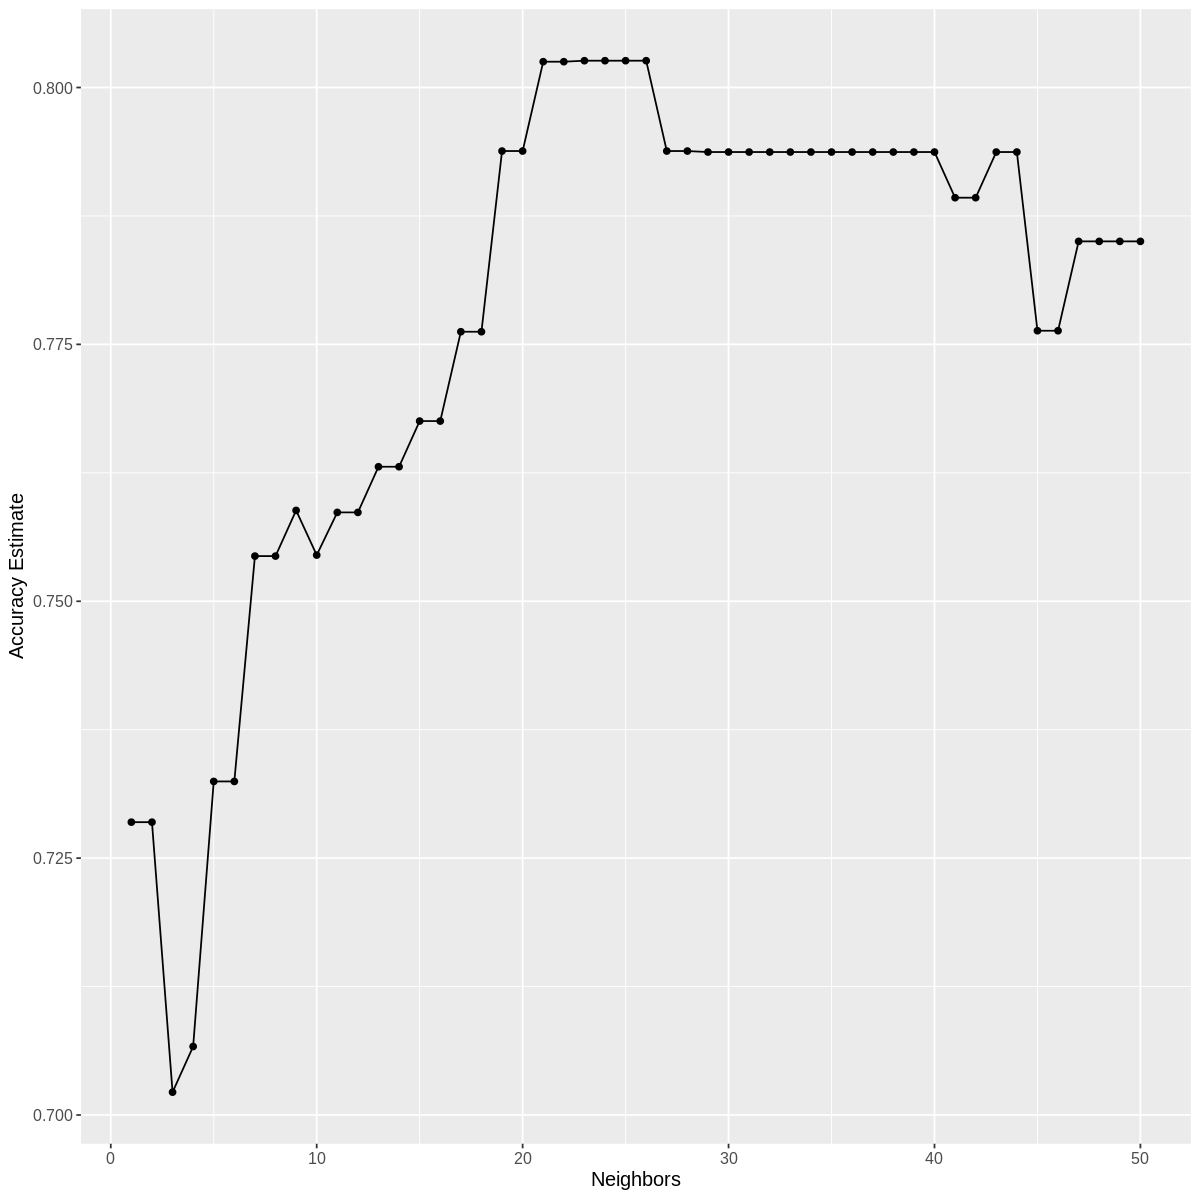

In [65]:
accuracy_vs_k_mut <- ggplot(accuracies_mut, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k_mut

In [18]:
accuracies_final_mut <- heart_disease_metrics_mut %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)
accuracies_final_mut

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
26,accuracy,binary,0.8026087,5,0.01386701,Model26


In [68]:
knn_spec_mut <- nearest_neighbor(weight_func = "rectangular", neighbors = 26) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")
knn_spec_mut

knn_fit_mut <- workflow() %>% 
  add_recipe(heart_recipe_mut) %>% 
  add_model(knn_spec_mut) %>% 
  fit(data = heart_disease_train_mut)
knn_fit_mut

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 26
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~26, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2324561
Best kernel: rectangular
Best k: 26

In [69]:
heart_prediction_mut <- predict(knn_fit_mut, heart_disease_test_mut) %>% 
                    bind_cols(heart_disease_test_mut)

heart_metrics_mut <- heart_prediction_mut %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat_mut <- heart_prediction_mut %>% 
                 conf_mat(truth = num, estimate = .pred_class)

heart_prediction_mut
heart_metrics_mut
mnist_conf_mat_mut

.pred_class,cp,thalach,exang,slope,oldpeak,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,3,187,0,3,3.5,0
0,2,178,0,1,0.8,0
1,4,160,0,3,3.6,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,4,90,0,2,1.0,1
1,4,123,1,2,0.2,1
1,4,141,0,2,3.4,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8133333


          Truth
Prediction  0  1
         0 35  8
         1  6 26

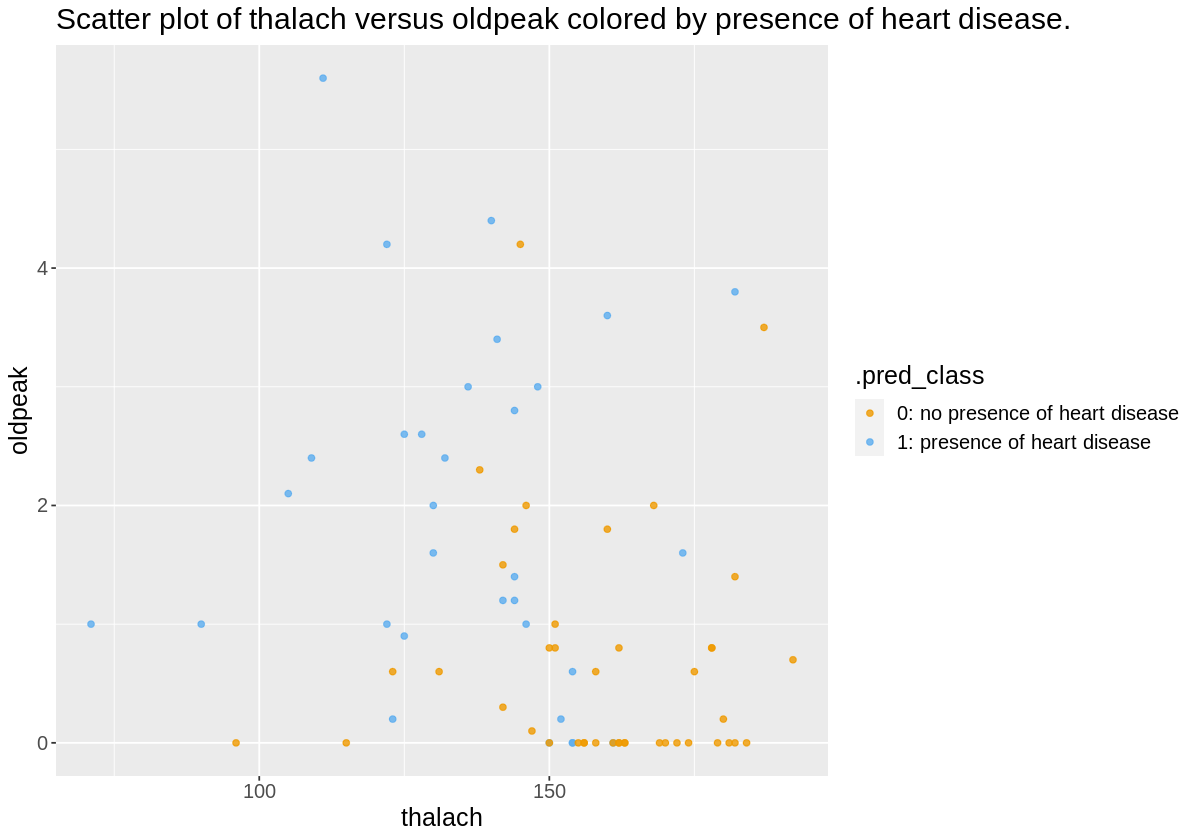

In [70]:
options(repr.plot.width = 10, repr.plot.height = 7)


two_predictors_ <- heart_prediction_mut %>%
  ggplot(aes(x = thalach, y = oldpeak, color = .pred_class)) +
  geom_point(alpha = 0.8) +
  labs(color = ".pred_class") +
  scale_color_manual(labels = c("0: no presence of heart disease", "1: presence of heart disease"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 15))+
  ggtitle("Scatter plot of thalach versus oldpeak colored by presence of heart disease.")

two_predictors_

*Figure 3: Scatter plot of thalach versus oldpeak colored by presence of heart disease.*

This graph shows the relationship between thalach and oldpeak

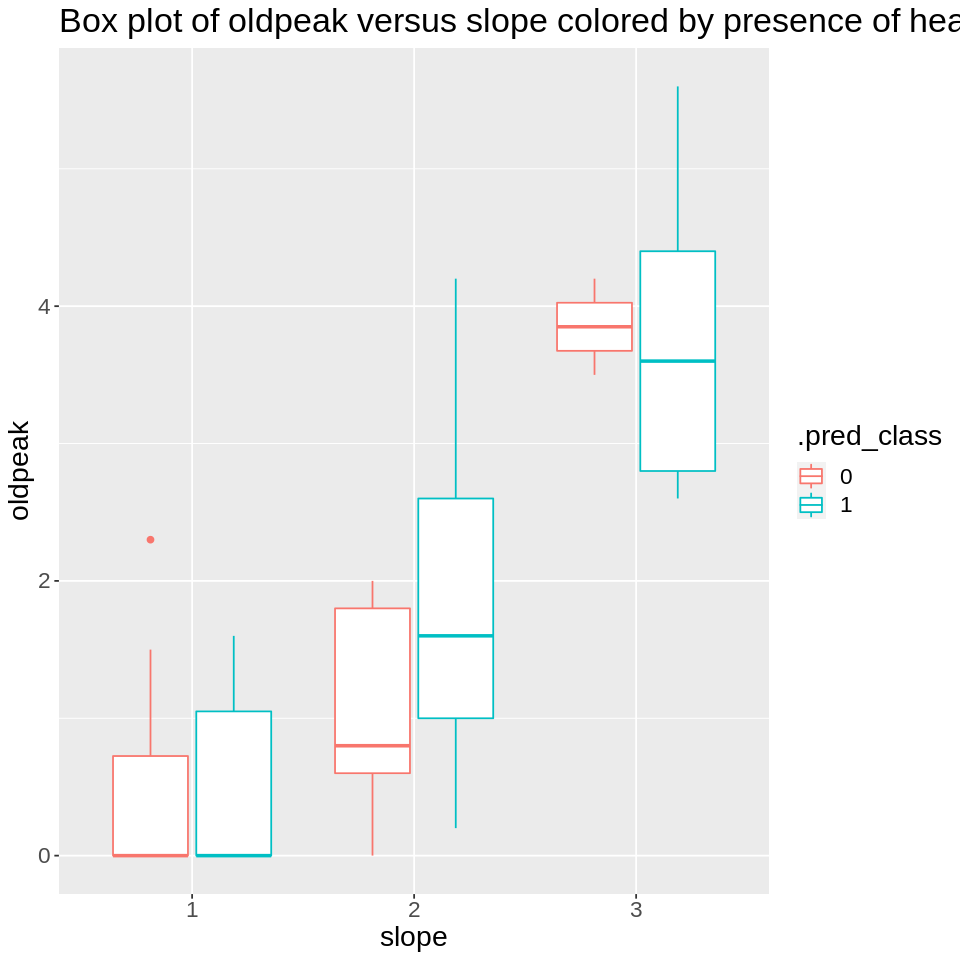

In [71]:
options(repr.plot.width = 8, repr.plot.height = 8)


two_predictors_111 <- heart_prediction_mut %>%
    mutate(slope = as.factor(slope)) %>% 
  ggplot(aes(x = slope, y = oldpeak, color = .pred_class)) +
  geom_boxplot() +
  theme(text = element_text(size = 17))+
  ggtitle("Box plot of oldpeak versus slope colored by presence of heart disease")

two_predictors_111

*Figure 4: Box plot of oldpeak versus slope colored by presence of heart disease.*

We infer that when an indivisual has the slope of the peak exercise ST segment Value at 2, then there is a high chance that the individual will have a presence of heart disease given its oldpeak(ST depression induced by exercise relative to rest) is above 2.<br>
We can also infer that when an indivisual has the slope of the peak exercise ST segment Value at 3, then there is a high chance that the individual will have a presence of heart disease given its oldpeak(ST depression induced by exercise relative to rest) is above 4.2 or below 3.5.<br>
Since the distribution of oldpeak given slope equals to 1 are about the same, we cannot predict one's presence of heart disease only from slope equals to 1.

In [72]:
options(repr.plot.width = 8, repr.plot.height = 8)

two_predictors_222 <- heart_prediction_mut %>%
    mutate(cp=as.factor(cp),exang=as.factor(exang))%>%
    group_by(cp,exang) %>%
    summarize(n= n())
# heart_prediction_mut_with_n <- heart_prediction_mut %>% 
#                         bind_cols(two_predictors_222)

    
# kkk <- two_predictors_222%>%
#   ggplot(aes(x = cp, y = n, color = .pred_class)) +
#   geom_point() +
#     labs(x="chest pain", y="exang", color = "prediction")
#   theme(text = element_text(size = 17))+
#   ggtitle("Box plot of oldpeak versus slope colored by presence of heart disease")

two_predictors_222



`summarise()` regrouping output by 'cp' (override with `.groups` argument)



cp,exang,n
<fct>,<fct>,<int>
1,0,3
1,1,2
2,0,11
⋮,⋮,⋮
3,1,3
4,0,19
4,1,21


In [73]:
mosaicplot(mnist_conf_mat_mut)

ERROR: Error in tabulate(Ind[, dimd]): 'bin' must be numeric or a factor


### FINAL Visualization

In [25]:
# pred_vs_actual <- heart_prediction_mut %>% 
#                 select(.pred_class, cp, num) %>% 
                
                

In [26]:
num_of_false_negative<-select(heart_prediction_mut, .pred_class == 1)

ERROR: Error: object '.pred_class' not found


## Predictions without balancing
   In the initial work, we did not check that the proportion of data being predicted was balanced, resulting in a low accuracy of this prediction method.
   In this prediction method, all codes are used in the same way as the 5 predictors above.I won't go into details here.

In [4]:
heart_disease_data_sa <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    select(sex, age, cp, thalach, exang, slope, oldpeak, num) %>% 
                    mutate(num = as.factor(num))
heart_disease_data_sa

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



sex,age,cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,63,1,150,0,3,2.3,0
1,67,4,108,1,2,1.5,2
1,67,4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,57,4,115,1,2,1.2,3
0,57,2,174,0,2,0.0,1
1,38,3,173,0,1,0.0,0


In [5]:
heart_disease_split <- initial_split(heart_disease_data_sa, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

head(heart_disease_data_sa, 10)

sex,age,cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,63,1,150,0,3,2.3,0
1,67,4,108,1,2,1.5,2
1,67,4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,57,4,163,1,1,0.6,0
1,63,4,147,0,2,1.4,2
1,53,4,155,1,3,3.1,1


In [6]:
summary(heart_disease_train)

      sex            age              cp           thalach          exang      
 Min.   :0.00   Min.   :29.00   Min.   :1.000   Min.   : 71.0   Min.   :0.000  
 1st Qu.:0.00   1st Qu.:48.00   1st Qu.:3.000   1st Qu.:132.0   1st Qu.:0.000  
 Median :1.00   Median :56.00   Median :4.000   Median :152.0   Median :0.000  
 Mean   :0.69   Mean   :54.48   Mean   :3.227   Mean   :148.6   Mean   :0.345  
 3rd Qu.:1.00   3rd Qu.:61.00   3rd Qu.:4.000   3rd Qu.:165.0   3rd Qu.:1.000  
 Max.   :1.00   Max.   :77.00   Max.   :4.000   Max.   :202.0   Max.   :1.000  
     slope         oldpeak      num    
 Min.   :1.00   Min.   :0.000   0:123  
 1st Qu.:1.00   1st Qu.:0.000   1: 43  
 Median :2.00   Median :0.800   2: 27  
 Mean   :1.62   Mean   :1.049   3: 27  
 3rd Qu.:2.00   3rd Qu.:1.600   4:  9  
 Max.   :3.00   Max.   :6.200          

`summarise()` regrouping output by 'num' (override with `.groups` argument)



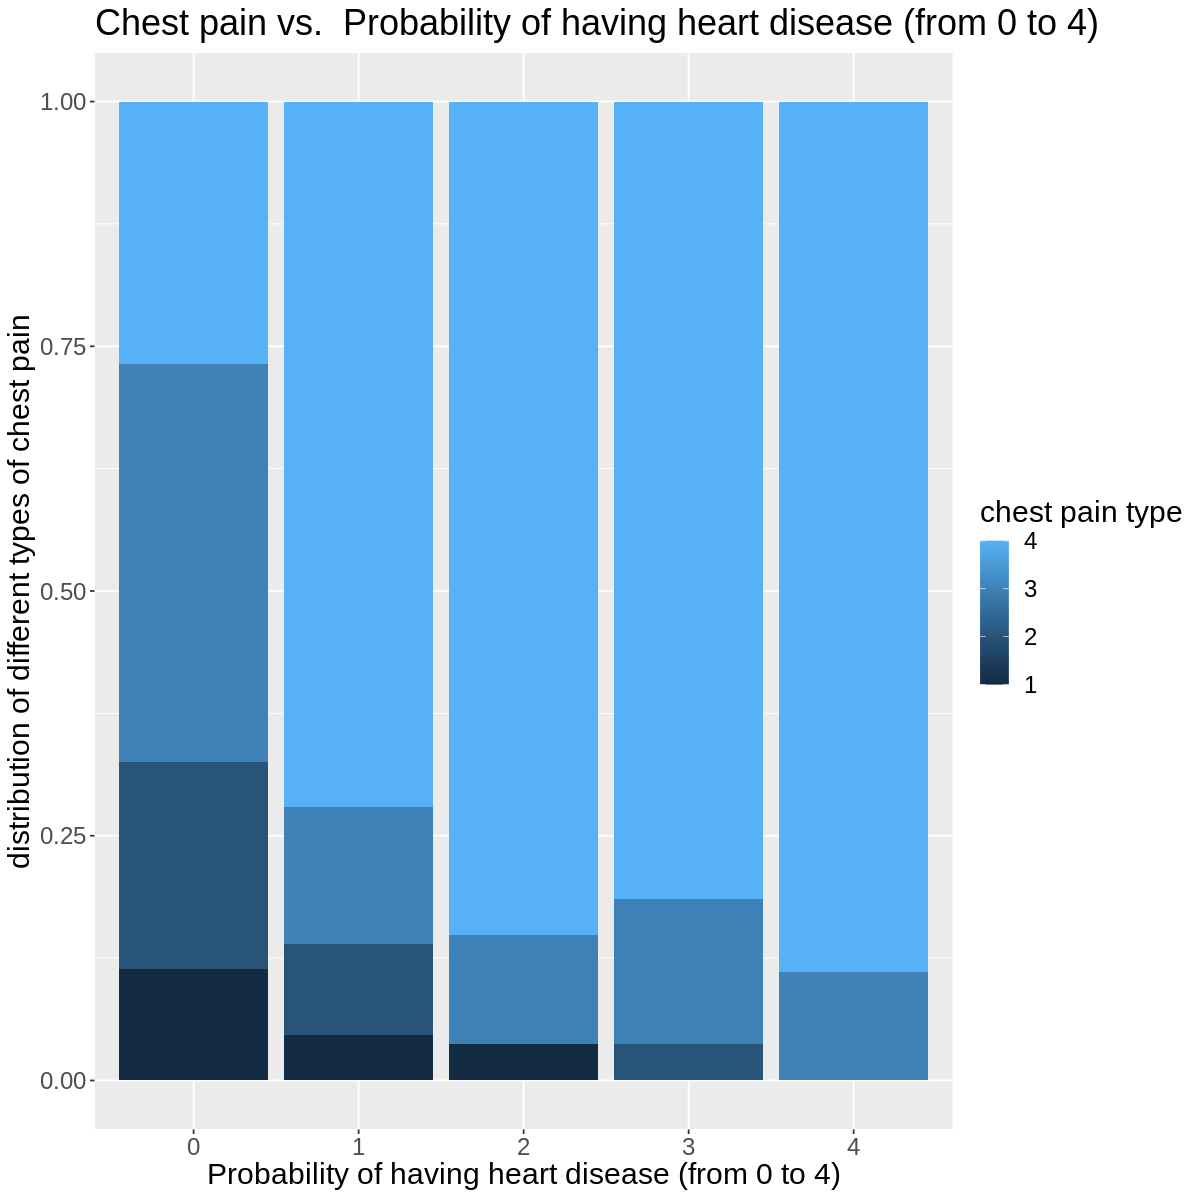

In [7]:
options(repr.plot.width = 10, repr.plot.height = 10) 

sex_vs_heart_disease <- heart_disease_train %>% 
                        select(num, cp) %>% 
                        group_by(num, cp) %>% 
                        summarize(n = n()) %>% 
                        ggplot(aes(x = num, y = n, fill = cp)) +
                        geom_bar(stat = "identity",position = "fill") +
                        labs(x =  "Probability of having heart disease (from 0 to 4)", y = "distribution of different types of chest pain", fill = "chest pain type") +
                        ggtitle("Chest pain vs.  Probability of having heart disease (from 0 to 4)") +
                        theme(text = element_text(size = 18))
sex_vs_heart_disease

In [8]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification") 
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [9]:
heart_recipe <- recipe(num ~ ., data = heart_disease_train)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

In [10]:
# FITTING Model

k_lots <- tibble(neighbors = seq(from = 1, to = 50, by = 5))
knn_fit <- workflow() %>% 
            add_recipe(heart_recipe) %>% 
            add_model(knn_spec) %>% 
            tune_grid(resamples = heart_disease_vfold, grid = k_lots)

! Fold1: internal: No observations were detected in `truth` for level(s): '4'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4797845,5,0.02594622,Model01
6,accuracy,multiclass,0.5937435,5,0.02882131,Model02
11,accuracy,multiclass,0.5890923,5,0.01813757,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
36,accuracy,multiclass,0.5686074,5,0.01628669,Model08
41,accuracy,multiclass,0.5726560,5,0.01345681,Model09
46,accuracy,multiclass,0.5602859,5,0.02024686,Model10


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,multiclass,0.5937435,5,0.02882131,Model02


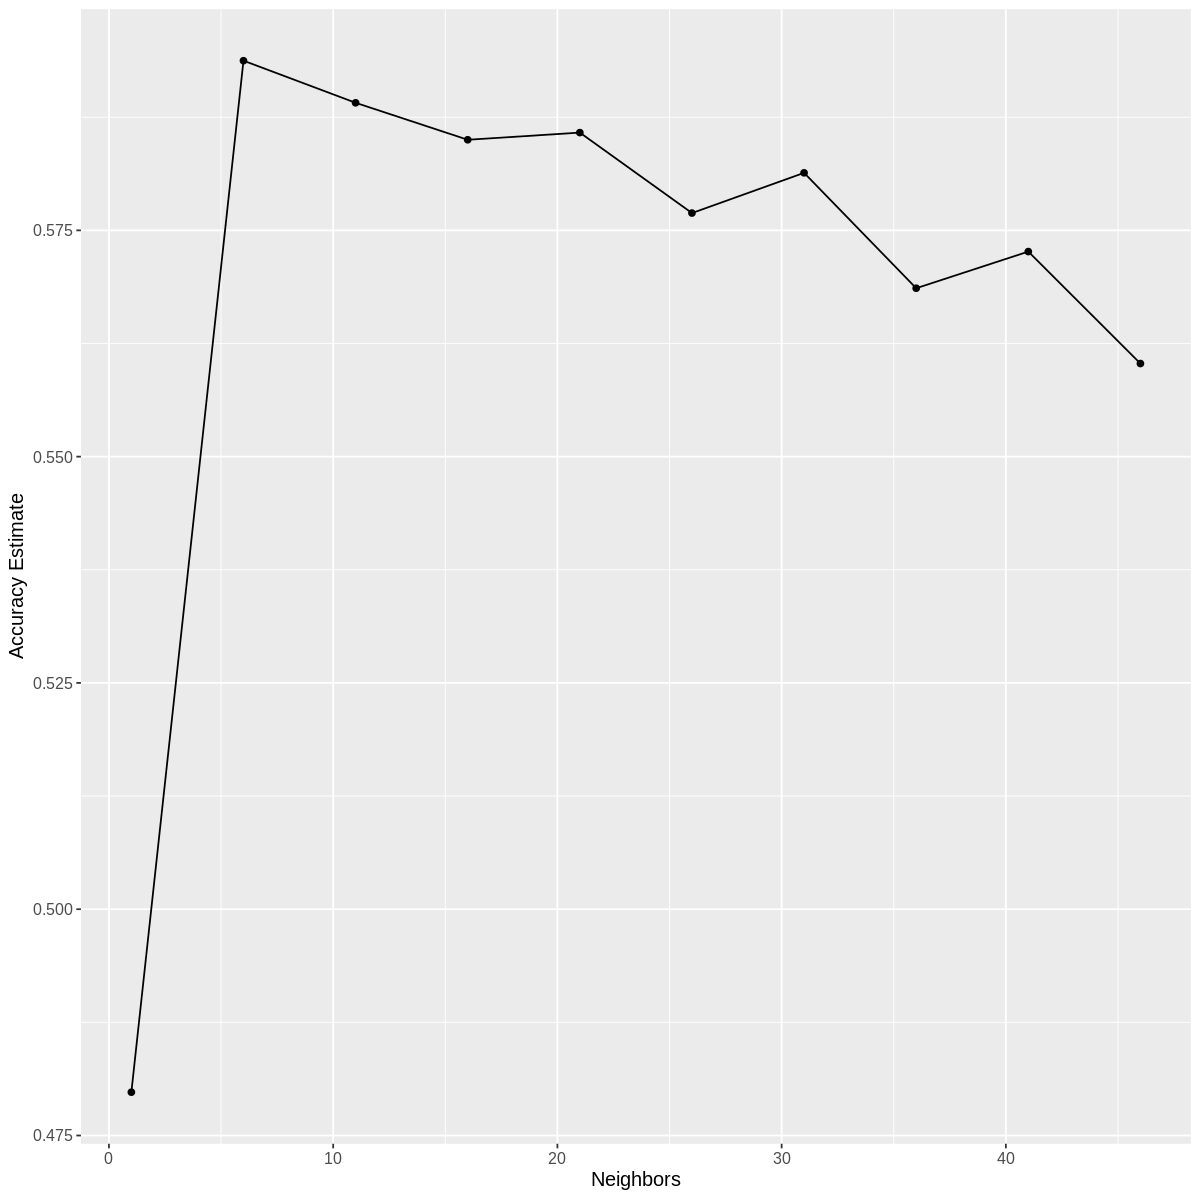

In [11]:
# set metrics

heart_disease_metrics <- knn_fit %>% 
                        collect_metrics()

accuracies <- heart_disease_metrics %>% 
        filter(.metric == "accuracy") 
accuracies
    
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

accuracies_final <- heart_disease_metrics %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)
accuracies_final

In [12]:
# knn_tune

knn_spec_sa <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_sa <- workflow() %>% 
  add_recipe(heart_recipe) %>% 
  add_model(knn_spec_sa) %>% 
  fit(data = heart_disease_train)

In [13]:
# make predictions

heart_prediction <- predict(knn_fit_sa, heart_disease_test) %>% 
                    bind_cols(heart_disease_test)

heart_metrics <- heart_prediction %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat <- heart_prediction %>% 
                 conf_mat(truth = num, estimate = .pred_class)
heart_metrics
mnist_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5675676


          Truth
Prediction  0  1  2  3  4
         0 38  9  1  4  1
         1  2  0  3  3  0
         2  1  1  4  0  3
         3  0  2  0  0  0
         4  0  0  1  1  0

In [17]:
heart_recipe_sa <- recipe(num ~ cp + thalach + exang + slope, data = heart_disease_train)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

! Fold1: internal: No observations were detected in `truth` for level(s): '4'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4148792,5,0.01204769,Model01
2,accuracy,multiclass,0.4148792,5,0.01204769,Model02
3,accuracy,multiclass,0.4715942,5,0.02108484,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,multiclass,0.5851208,5,0.02287398,Model48
49,accuracy,multiclass,0.5851208,5,0.02287398,Model49
50,accuracy,multiclass,0.5807729,5,0.02419485,Model50


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
28,accuracy,multiclass,0.6024155,5,0.02094079,Model28


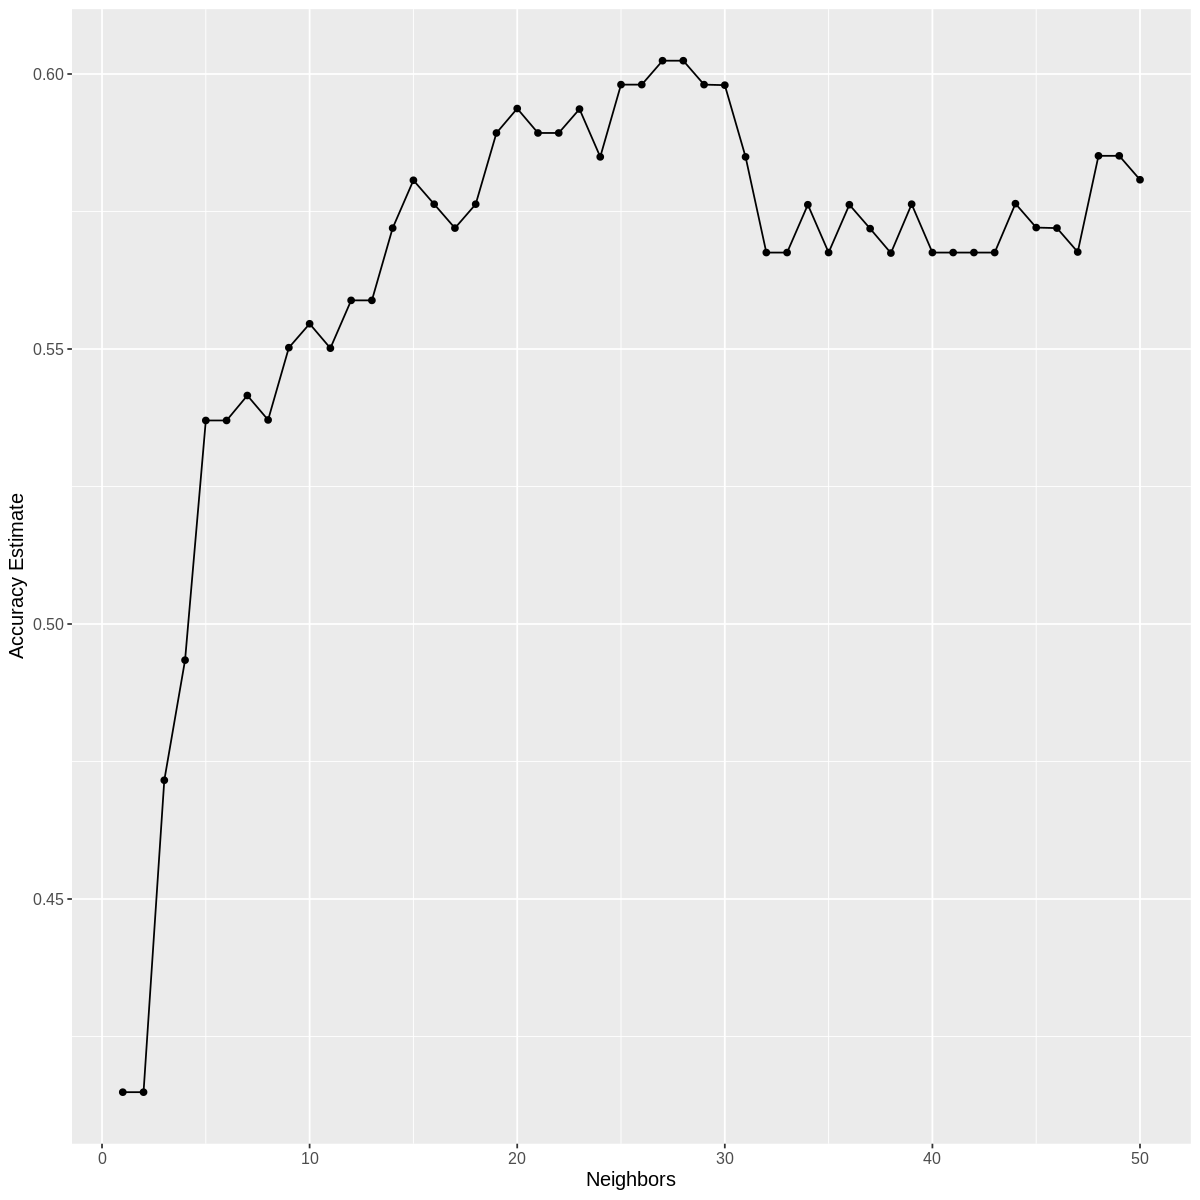

In [18]:
# FITTING Model
k_lots <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_fit_sa <- workflow() %>% 
            add_recipe(heart_recipe_sa) %>% 
            add_model(knn_spec) %>% 
            tune_grid(resamples = heart_disease_vfold, grid = k_lots)

heart_disease_metrics_sa <- knn_fit_sa %>% 
                        collect_metrics()

accuracies_sa <- heart_disease_metrics_sa %>% 
        filter(.metric == "accuracy") 
accuracies_sa
    
accuracy_vs_k_sa <- ggplot(accuracies_sa, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k_sa

accuracies_final_sa <- heart_disease_metrics_sa %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)

accuracies_final_sa

In [21]:
knn_spec_sa <- nearest_neighbor(weight_func = "rectangular", neighbors = 28) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_sa <- workflow() %>% 
  add_recipe(heart_recipe_sa) %>% 
  add_model(knn_spec_sa) %>% 
  fit(data = heart_disease_train)

In [23]:
heart_prediction_sa <- predict(knn_fit_sa, heart_disease_test) %>% 
                    bind_cols(heart_disease_test)

heart_metrics_sa <- heart_prediction_sa %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat_sa <- heart_prediction_sa %>% 
                 conf_mat(truth = num, estimate = .pred_class)
heart_metrics_sa
mnist_conf_mat_sa

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5675676


          Truth
Prediction  0  1  2  3  4
         0 39  9  4  4  3
         1  2  1  3  2  0
         2  0  0  0  0  0
         3  0  2  2  2  1
         4  0  0  0  0  0

`Like we said above, if the distribution of the predicted values is not balanced in terms of their proportion, it leads to a prediction method that is difficult to be accurate and is overly influenced by the predictors corresponding to a single over-represented predicted value, thus resulting in very inaccurate results.`

## 4 predictors
`Although the prediction method we finally choose contains five predictors, we start if the correlation between each predictor and the value to be predicted is less than 0.5, so if we reduce the number of predictors, will the prediction method have less error and thus become more accurate. With the same code, we found that this is not the case and we found that after removing a slope factor, we got the same result as the prediction method with 5 predictors.`

Because the content of the code and the above two are the same, here also do not go into detail, only the analysis of the results.

In [49]:
heart_disease_data_4 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    mutate(num = replace(num, num =='2',1)) %>% 
                    mutate(num = replace(num, num =='3',1)) %>% 
                    mutate(num = replace(num, num =='4',1)) %>% 
                    mutate(num = as.factor(num)) %>% 
                    select(cp, thalach, exang, oldpeak, num) 
heart_disease_data_4

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,2.3,0
4,108,1,1.5,1
4,129,1,2.6,1
⋮,⋮,⋮,⋮,⋮
4,115,1,1.2,1
2,174,0,0.0,1
3,173,0,0.0,0


In [50]:
set.seed(1234)
heart_disease_split_mut_4 <- initial_split(heart_disease_data_4, prop = 0.75, strata = num)
heart_disease_train_mut_4 <- training(heart_disease_split_mut_4)
heart_disease_test_mut_4 <- testing(heart_disease_split_mut_4)

head(heart_disease_data_4,10)

cp,thalach,exang,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,2.3,0
4,108,1,1.5,1
4,129,1,2.6,1
⋮,⋮,⋮,⋮,⋮
4,163,1,0.6,0
4,147,0,1.4,1
4,155,1,3.1,1


In [51]:
knn_spec_mut_4 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification") 

In [52]:
heart_recipe_mut_4 <- recipe(num ~ ., data = heart_disease_train_mut_4)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold_mut_4 <- vfold_cv(heart_disease_train_mut_4, v = 5, strata = num)

In [53]:
k_lots_mut_4 <- tibble(neighbors = seq(from = 1, to = 80, by = 5))

knn_fit_mut_4 <- workflow() %>% 
            add_recipe(heart_recipe_mut_4) %>% 
            add_model(knn_spec_mut_4) %>% 
            tune_grid(resamples = heart_disease_vfold_mut_4, grid = k_lots_mut_4)

In [54]:
heart_disease_metrics_mut_4 <- knn_fit_mut_4 %>% 
                        collect_metrics()

accuracies_mut_4 <- heart_disease_metrics_mut_4 %>% 
        filter(.metric == "accuracy") 
    
accuracy_vs_k_mut_4 <- ggplot(accuracies_mut_4, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracies_final_mut_4 <- heart_disease_metrics_mut_4 %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)
accuracies_final_mut_4

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
56,accuracy,binary,0.7849275,5,0.009147417,Model12


In [55]:
final_k_for_4predictors <- accuracies_final_mut_4 %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)%>%select(neighbors)%>%pull()
final_k_for_4predictors

[1] 56

In [56]:
knn_spec_mut_4 <- nearest_neighbor(weight_func = "rectangular", neighbors = final_k_for_4predictors) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")
knn_fit_mut_4 <- workflow() %>% 
  add_recipe(heart_recipe_mut_4) %>% 
  add_model(knn_spec_mut_4) %>% 
  fit(data = heart_disease_train_mut_4)

In [57]:
heart_prediction_mut_4 <- predict(knn_fit_mut_4, heart_disease_test_mut_4) %>% 
                    bind_cols(heart_disease_test_mut_4)

heart_metrics_mut_4 <- heart_prediction_mut_4 %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat_mut_4 <- heart_prediction_mut_4 %>% 
                 conf_mat(truth = num, estimate = .pred_class)

heart_prediction_mut_4
heart_metrics_mut_4
mnist_conf_mat_mut_4

.pred_class,cp,thalach,exang,oldpeak,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,3,187,0,3.5,0
0,2,178,0,0.8,0
1,4,160,0,3.6,1
⋮,⋮,⋮,⋮,⋮,⋮
1,4,90,0,1.0,1
1,4,123,1,0.2,1
1,4,141,0,3.4,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8133333


          Truth
Prediction  0  1
         0 36  9
         1  5 25

In [44]:
#source("cleanup.R")